## Week 2
### Model quality and decision making. Benefit curve

In this jupyter-notebook we will learn how to calculate the profit of using the better model

#### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score as f1

import matplotlib.colors


sns.set(style="white")

np.random.seed(2020)

#settings for plots
plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize' : 14, 
                     'ytick.labelsize' : 14,
                     'axes.labelsize' : 16,
                     'axes.titlesize' : 20})

In [2]:
import warnings
warnings.filterwarnings("ignore")

Define some functions that will help us to plot graphs. 

In [3]:
def roc_auc_plot(model, X_train, y_train,
                X_oos, y_oos, X_oot, y_oot, names = ['train', 'oos' ]):
    
    plt.figure(figsize=(10,8))
    colors = ['olivedrab','deepskyblue',  'salmon']
    
    for it, i in enumerate(names):
        
        #choose the data
        if i == 'train':
            X = X_train
            y_ = y_train
        elif i == 'oos':
            X = X_oos
            y_ = y_oos
        else:
            X = X_oot
            y_ = y_oot
        
        y_hat = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_, y_hat)
        gini = 2 * roc_auc_score(y_, y_hat) - 1
        plt.plot(fpr, tpr, label = i, color = colors[it], linewidth=2)
        print('Model',i, 'gini: ', np.round(gini,2))

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Model old')
    plt.legend(bbox_to_anchor=(1, 1));
    plt.plot([0,1], [0,1], '--', color='grey', label='Random model')

    plt.grid()
    _ = plt.legend(loc= 0, prop= {'size': 16})

In [4]:
def benefit_plot(model, X_train, y_train,
                X_oos, y_oos, X_oot, y_oot, names = ['train', 'oos' ]):
                 
    plt.figure(figsize=(10,8))

    colors = ['olivedrab','deepskyblue',  'salmon']
    
    max_val = []
    for it, i in enumerate(names):

        if i == 'train':
            X = X_train
            y_ = y_train
        elif i == 'oos':
            X = X_oos
            y_ = y_oos
        else:
            X = X_oot
            y_ = y_oot

        benefit = []    
        c_acceptance_rate = []
        
        y_hat = model.predict_proba(X)[:, 1]
        
        for t in thr:
            #calculate confusion matrix
            CM = confusion_matrix(y_, (y_hat > t)*1.)  
            
            #calculate accaptance rate as amount of non-defaulted clients
            c_acceptance_rate.append((len(y_hat) - np.sum((y_hat > t)*1.)) / len(y_hat))
            TN = CM[0][0]
            FN = CM[1][0]
            FP = CM[0][1]
            
            #calculate the financial effect
            benefit.append(TN * e_fp - FN * e_fn)

        fpr, tpr, _ = roc_curve(y_, y_hat)
        gini = 2 * roc_auc_score(y_, y_hat) - 1
        print('Model',i, 'gini: ', np.round(gini,2)) 
        print('Model',i, 'Max Benefit: ', np.max(benefit)) 
        
        plt.plot(c_acceptance_rate, benefit, label = i, color = colors[it], linewidth=2)  
        plt.plot(c_acceptance_rate[np.argmax(benefit)], np.max(benefit), color = colors[it], marker='*', markersize=10)
         


    plt.xlabel('Acceptance rate')
    plt.ylabel('Benefit')
    plt.title('Benefit curve for old model')
    plt.legend(bbox_to_anchor=(1, 1));

    plt.grid()
    _ = plt.legend(loc= 0, prop= {'size': 16})
    


__Consider a binary classification model $X -> Prob$, e.g. credit scoring__:

#### Load Data

Load **train**, **out-of-sample** and **out-of-time** samples

In [5]:
!test -d data/w2 || mkdir -p data/w2
!cd data/w2 && kaggle competitions download -c GiveMeSomeCredit
!cd data/w2 && unzip GiveMeSomeCredit.zip

 97%|████████████████████████████████████▊ | 5.00M/5.16M [00:00<00:00, 21.4MB/s]
100%|██████████████████████████████████████| 5.16M/5.16M [00:00<00:00, 21.5MB/s]
Archive:  GiveMeSomeCredit.zip
  inflating: Data Dictionary.xls     
  inflating: cs-test.csv             
  inflating: cs-training.csv         
  inflating: sampleEntry.csv         


In [7]:
df_train = pd.read_csv('data/cs-training.csv')
df_oos = pd.read_csv('data/cs-test.csv')
# df_oot = pd.read_csv('data/df_oot.csv')
## based on kaggle https://www.kaggle.com/c/GiveMeSomeCredit

In [9]:
df_oos.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [6]:
df_train.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,365.59,12.92,10500,66400.0,6.0,36,0,7.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,535.54,19.11,15000,80000.0,10.0,36,1,2.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,517.16,26.55,22400,50000.0,10.0,60,4,2.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,342.66,5.74,9800,41000.0,0.0,36,1,4.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,381.46,4.88,17325,74000.0,10.0,60,1,6.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


__Column description:__

- `issue_d` - The month which the loan was funded
- `addr_state` - The state provided by the borrower in the loan application
- `emp_title` - The job title supplied by the Borrower when applying for the loan.
- `installment` - The monthly payment owed by the borrower if the loan originates.
- `dti` - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- `funded_amnt` - The total amount committed to that loan at that point in time.
- `annual_inc` - The self-reported annual income provided by the borrower during registration.
- `emp_length` - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- `term` - The number of payments on the loan. Values are in months and can be either 36 or 60.
- `inq_last_6mths` - The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- `mths_since_recent_inq` - Months since most recent inquiry.
- `delinq_2yrs` - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- `chargeoff_within_12_mths` - Number of charge-offs within 12 months
- `num_accts_ever_120_pd` - Number of accounts ever 120 or more days past due
- `num_tl_90g_dpd_24m` - Number of accounts 90 or more days past due in last 24 months
- `acc_open_past_24mths` - Number of trades opened in past 24 months.
- `avg_cur_bal` - Average current balance of all accounts
- `tot_hi_cred_lim` - Total high credit/credit limit
- `delinq_amnt` - The past-due amount owed for the accounts on which the borrower is now delinquent.

And all categorical variables are encoded:
- `sub_grade` - External assigned loan subgrade
- `purpose` - A category provided by the borrower for the loan request.
- `home_ownership` - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER


__Target variable:__
- `def`

#### Modelling

##### *1. Define target*

In [7]:
targ_cols = [i for i in df_train.columns if i != 'def']

X_train = df_train[targ_cols]
X_oos = df_oos[targ_cols]
X_oot = df_oot[targ_cols]

y_train = df_train["def"]
y_oos = df_oos["def"]
y_oot = df_oot["def"]

##### *2. Define FP and FN costs*

Financial result of model performance depends on FP and FN error

In [8]:
S = 1000 # amount of loan
r = 0.03 # interest rate
lgd = 0.2 # losses in case of default
e_fp = r * S # 1 type error cost
e_fn = lgd * S # 2 type error cost

In [9]:
#the grid to calculate acceptance rate
thr = np.linspace(0,1,41) #41

##### 3.*Train old model*

In [10]:
model_old = LogisticRegression(C=0.02, fit_intercept=True, max_iter=100,
          penalty='l1', random_state=123, solver = 'liblinear',
          tol=0.01).fit(X_train, y_train)


model_old.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=123, solver='liblinear',
          tol=0.01, verbose=0, warm_start=False)

**Plot roc-auc** in order to compare the quality of model on different samples

Model train gini:  0.32
Model oos gini:  0.27


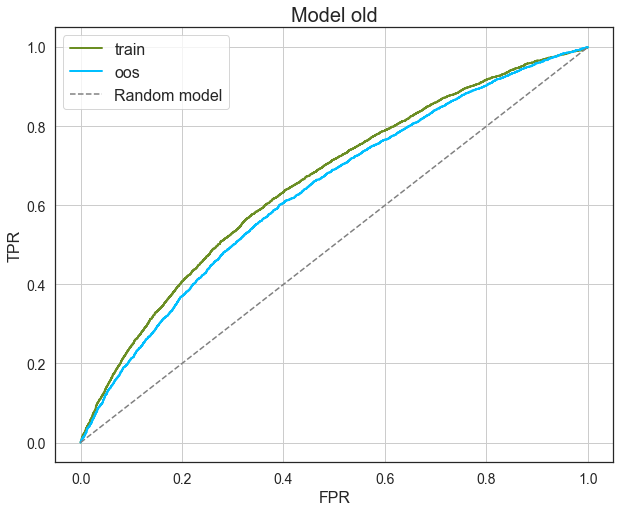

In [11]:
roc_auc_plot(model_old, X_train, y_train,
                X_oos, y_oos, X_oot, y_oot, ['train', 'oos' ])

We see that the quality of model on oos and oot data is lower than on the train

___
**Plot benefit curve** to see the dependence between the benefit and acceptance rate 

Simple threshold decision is a level $a$: 
if $Prob > a$ then some action is undertaken, i.e. $\hat{𝑌}=1$ and otherwise $\hat{𝑌}=0$


**Acceptance rate** $c$ is a percentage of observations that satisfy rule:
$$
if Prob \le a, i.e. c = \frac{\sum_{i=1}^{N}I\{Prob_i\le a\}}{N}
$$

We use the function that is defined above. For each acceptance rate we calculate the benefit:
1. Pick threshold level a. Calculate c (x axis)
2. Calculate FP and FN for given c
3. Weigh FP and FN with error costs (e_FP and e_FN) and plot on y axis
4. Reiterate 1-3 from $c = 0$ to $c = 1$

Model train gini:  0.32
Model train Max Benefit:  68100.0
Model oos gini:  0.27
Model oos Max Benefit:  52530.0


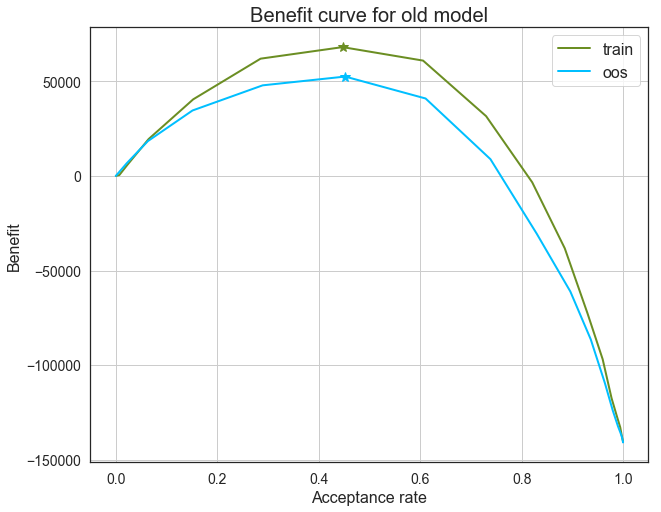

In [12]:
benefit_plot(model_old, X_train, y_train, X_oos, y_oos, 
                X_oot, y_oot,['train', 'oos' ])

##### 4.*Train new model*

Define better model with optimized hyperparameters (outside this notebook)

You can also train your own more complex model (random forest or gradient-boosting models)

In [13]:
model_new = LogisticRegression(C=2, fit_intercept=True, max_iter=100,
          penalty='l1', random_state=123, solver = 'liblinear',
          tol=0.01).fit(X_train, y_train)

model_new.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=123, solver='liblinear',
          tol=0.01, verbose=0, warm_start=False)

**Plot roc-auc** in order to compare the quality of model on different samples

Model train gini:  0.39
Model oos gini:  0.35


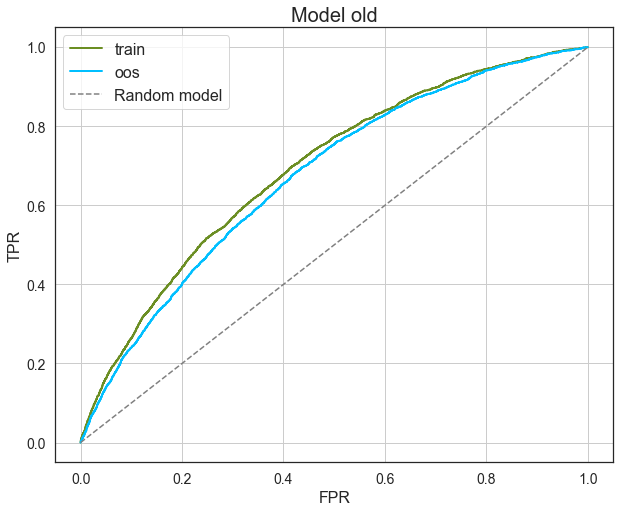

In [14]:
roc_auc_plot(model_new, X_train, y_train,X_oos, y_oos, 
                X_oot, y_oot, ['train', 'oos'])

**Plot benefit curve** to see the dependence between the benefit and acceptance rate 

Model train gini:  0.39
Model train Max Benefit:  102560.0
Model oos gini:  0.35
Model oos Max Benefit:  91990.0


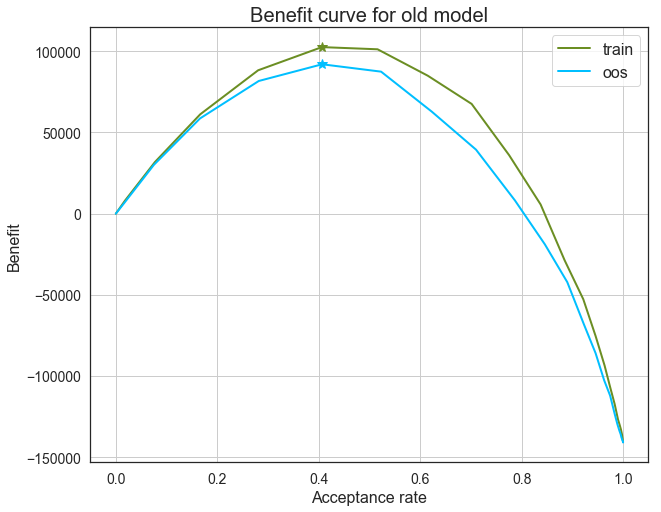

In [15]:
benefit_plot(model_new, X_train, y_train, X_oos, y_oos, 
                X_oot, y_oot, ['train', 'oos'])

In our example we get that the higher model quality metrics are, the higher is financial result (in general)